In [21]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as fn
from pyspark.conf import SparkConf

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
#Read Data From Postgres using PySpark
sc = SparkSession.builder\
    .config("spark.jars", "./postgresql_jdbc/postgresql-42.6.0.jar")\
    .config("spark.driver.extraClassPath", "./postgresql_jdbc/postgresql-42.6.0.jar")\
    .config("spark.executor.extraClassPath", "./postgresql_jdbc/postgresql-42.6.0.jar")\
    .getOrCreate()

sqlContext = SQLContext(sc)

city_distances = sc.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bdm_joint") \
    .option("dbtable", "city_distances") \
    .option("user", "bdm") \
    .option("password", "test123") \
    .option("driver", "org.postgresql.Driver") \
    .load()

flights = sc.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bdm_joint") \
    .option("dbtable", "flights") \
    .option("user", "bdm") \
    .option("password", "test123") \
    .option("driver", "org.postgresql.Driver") \
    .load()


products = sc.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bdm_joint") \
    .option("dbtable", "products") \
    .option("user", "bdm") \
    .option("password", "test123") \
    .option("driver", "org.postgresql.Driver") \
    .load()

requests = sc.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bdm_joint") \
    .option("dbtable", "requests") \
    .option("user", "bdm") \
    .option("password", "test123") \
    .option("driver", "org.postgresql.Driver") \
    .load()

travels = sc.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bdm_joint") \
    .option("dbtable", "travels") \
    .option("user", "bdm") \
    .option("password", "test123") \
    .option("driver", "org.postgresql.Driver") \
    .load()

users = sc.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bdm_joint") \
    .option("dbtable", "users") \
    .option("user", "bdm") \
    .option("password", "test123") \
    .option("driver", "org.postgresql.Driver") \
    .load()

D:\Anaconda3\envs\ADA\lib\site-packages\pyspark\context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)
D:\Anaconda3\envs\ADA\lib\site-packages\pyspark\sql\context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


## 1. Exploration

In [3]:
city_distances.printSchema()

root
 |-- country1: string (nullable = true)
 |-- name1: string (nullable = true)
 |-- country2: string (nullable = true)
 |-- name2: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- lpg_price: double (nullable = true)
 |-- diesel_price: double (nullable = true)
 |-- gasoline_price: double (nullable = true)



In [4]:
city_distances.take(1)

[Row(country1='Spain', name1='Madrid', country2='Spain', name2='Alacant', distance_km=360.1276166, currency='euro', lpg_price=28.03233368, diesel_price=27.72982648, gasoline_price=36.82268867)]

### 1.1 Show those tables in pandas Dataframe format

In [5]:
city_distances.toPandas()

,country1,name1,country2,name2,distance_km,currency,lpg_price,diesel_price,gasoline_price
0,Spain,Madrid,Spain,Alacant,360.127617,euro,28.032334,27.729826,36.822689
1,Spain,Madrid,Spain,Málaga,414.957672,euro,32.300305,31.951741,42.429007
2,Spain,Madrid,Spain,Sevilla,390.504192,euro,30.396846,30.068823,39.928663
3,Spain,Madrid,Spain,Palma,550.581189,euro,42.857240,42.394752,56.296376
4,Spain,Madrid,Spain,Barcelona,506.922016,euro,39.458810,39.032995,51.832269
5,Spain,Alacant,Spain,Málaga,391.476854,euro,30.472558,30.143718,40.028117
6,Spain,Alacant,Spain,Sevilla,495.959990,euro,38.605526,38.188919,50.711413
7,Spain,Alacant,Spain,Palma,304.141921,euro,23.674407,23.418928,31.098207
8,Spain,Alacant,Spain,Barcelona,407.252380,euro,31.700525,31.358433,41.641149
9,Spain,Málaga,Spain,Sevilla,158.358120,euro,12.326596,12.193575,16.191959


In [6]:
flights.toPandas()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,departureTime,arrivalTime,stops,departureTerminal,arrivalTerminal
0,1007,MAD,BCN,2023/4/23 18:25,2023/4/23 19:45,0,4.0,1.0
1,5005,MAD,BCN,2023/4/23 18:25,2023/4/23 19:45,0,4.0,1.0
2,3546,MAD,BCN,2023/4/23 18:25,2023/4/23 19:45,0,4.0,1.0
3,7703,MAD,BCN,2023/4/23 15:10,2023/4/23 16:35,0,2.0,1.0
4,9459,MAD,BCN,2023/4/23 15:10,2023/4/23 16:35,0,2.0,1.0
...,...,...,...,...,...,...,...,...
3929,3150,AGP,PMI,2023/4/28 21:05,2023/4/28 22:35,0,NaN,NaN
3930,5259,AGP,PMI,2023/4/28 21:05,2023/4/28 22:35,0,NaN,NaN
3931,5677,AGP,PMI,2023/4/29 21:35,2023/4/29 23:05,0,NaN,NaN
3932,3148,AGP,PMI,2023/4/29 13:35,2023/4/29 15:05,0,NaN,NaN


In [7]:
products.toPandas()

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_name
0,1e9e8ef04dbcff4541ed26657ea517e5,225,16,10,14,perfumery,Acqua di Gio by Giorgio Armani
1,6a2fb4dd53d2cdb88e0432f1284a004c,400,27,5,20,perfumery,Alien by Thierry Mugler
2,0d009643171aee696f4733340bc2fdd0,422,21,16,18,perfumery,Black Opium by Yves Saint Laurent
3,b1eae565a61935e0011ee7682fef9dc9,267,17,13,17,perfumery,Bleu de Chanel by Chanel
4,8da90b37f0fb171b4877c124f965b1f6,377,18,13,15,perfumery,Bright Crystal by Versace
...,...,...,...,...,...,...,...
120,91e6a181c1ebe734ab459822cee89763,850,48,16,25,watches_gifts,Tissot T-Touch
121,af8215adef2df1e9e66642f159e81e55,400,20,11,19,watches_gifts,Casio G-Shock
122,35255921c732e0e9319097469d856cd5,400,18,11,15,watches_gifts,Timex Weekender
123,25a675783383c8e0aa707b7e9063c925,253,18,11,13,watches_gifts,Fossil Grant


In [8]:
requests.toPandas()

,requestId,initializationUserId,collectionUserId,travellerId,productId,dateToDeliver,dateDelivered,requestDate,pickUpAddress,collectionAddress,deliveryFee,Satisfactory,dhl_fee
0,0,24,26,0.0,d68bd4dedccc5545b1ff6629de8fb021,2023-08-07 08:16:00,2023-08-03 08:55:00,2023-07-28 08:16:00,24,26,4.686061,t,17.05
1,1,28,33,15.0,b864b103180d5a6a3f830e67f93e8735,2023-09-16 22:08:00,2023-09-10 21:55:00,2023-09-06 22:08:00,28,33,3.880162,t,16.78
2,2,27,23,15.0,be1be330cf34043d1c40d6114cbd11b5,2023-08-22 04:37:00,2023-08-14 10:21:00,2023-08-11 04:37:00,27,23,2.644626,t,17.05
3,3,22,38,3.0,062e425d963f3eac04709162c3ce6782,2023-06-24 16:55:00,2023-06-24 15:34:00,2023-06-18 16:55:00,22,38,3.459768,t,16.78
4,4,29,37,19.0,dbb399a8be7395d5b136d49fcdce13df,2023-09-09 11:56:00,2023-09-01 17:27:00,2023-08-29 11:56:00,29,37,3.633162,t,16.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,24,31,NaN,c20fbbd4ccf2f7da70e150689a6a905f,2023-04-26 09:51:00,None,2023-04-16 09:51:00,24,31,NaN,None,16.78
216,216,21,38,NaN,dbb399a8be7395d5b136d49fcdce13df,2023-04-18 12:16:00,None,2023-04-11 12:16:00,21,38,NaN,None,17.05
217,217,23,38,NaN,483df9288035696f34225a7047591d13,2023-04-22 03:02:00,None,2023-04-11 03:02:00,23,38,NaN,None,17.05
218,218,39,24,NaN,3488d2ce36e718097c1509444289ef7f,2023-04-26 17:32:00,None,2023-04-15 17:32:00,39,24,NaN,None,16.78


In [9]:
travels.toPandas()

,userId,departureAirportFsCode,arrivalAirportFsCode,departureTime,arrivalTime,extraLuggage
0,0,Madrid,Barcelona,2023/4/22 20:00,2023/4/22 21:20,4
1,0,Barcelona,Madrid,2023/4/25 12:40,2023/4/25 14:05,7
2,1,Madrid,Barcelona,2023/4/19 15:10,2023/4/19 16:35,4
3,1,Barcelona,Madrid,2023/4/22 18:05,2023/4/22 19:30,3
4,2,Madrid,Barcelona,2023/4/19 20:00,2023/4/19 21:20,7
5,2,Barcelona,Madrid,2023/4/23 18:05,2023/4/23 19:30,4
6,3,Palma,Málaga,2023/4/21 6:45,2023/4/21 8:20,5
7,3,Málaga,Palma,2023/4/24 20:40,2023/4/24 22:05,3
8,4,Madrid,Barcelona,2023/4/19 16:30,2023/4/19 17:50,6
9,4,Barcelona,Madrid,2023/4/23 11:35,2023/4/23 13:05,4


In [10]:
users.toPandas()

,user_id,gender,nationality,dob,is_traveller,address,city
0,0,Female,Spain,1963/9/25,t,0,Palma
1,1,Male,Spain,1996/12/12,t,1,Palma
2,2,Female,Spain,1976/7/13,t,2,Barcelona
3,3,Male,Spain,1981/3/4,t,3,Madrid
4,4,Female,Spain,1968/3/16,t,4,Madrid
5,5,Male,Spain,1993/6/26,t,5,Palma
6,6,Female,Spain,1966/8/14,t,6,Palma
7,7,Male,Spain,2003/9/18,t,7,Palma
8,8,Female,Spain,1997/8/20,t,8,Málaga
9,9,Male,Spain,1967/12/9,t,9,Barcelona


## 2. Feature Engineering

### 2.1 Create Features and targets based on joining & Data Cleaning

In [11]:
new_requests = requests.join(users.select(["city","address"]), requests.pickUpAddress == users.address).\
drop("address").withColumnRenamed("city", 'startCity')

new_requests = new_requests.join(users.select(["city","address"]), new_requests.collectionAddress == users.address).\
drop("address").withColumnRenamed("city", 'endCity')

new_requests = new_requests.join(city_distances.select(["name1","name2","distance_km","lpg_price",
                                                       "diesel_price","gasoline_price"]), 
                                 ((new_requests.startCity == city_distances.name1) & \
                                  (new_requests.endCity == city_distances.name2)) | \
                                 ((new_requests.startCity == city_distances.name2) & \
                                  (new_requests.endCity == city_distances.name1))).drop("name1","name2")


new_requests = new_requests.join(products.select(["product_id","product_weight_g","product_length_cm",
                                                  "product_height_cm","product_width_cm"]), 
                                 (new_requests.productId == products.product_id)).drop("product_id")


new_requests = new_requests.select(["deliveryFee","Satisfactory","dhl_fee","distance_km","lpg_price",
                                    "diesel_price","gasoline_price","product_weight_g","product_length_cm",
                                   "product_height_cm","product_width_cm"]).withColumnRenamed("distance_km","Distance")


new_requests = new_requests.withColumn("Satisfactory", 
                                       when(new_requests.Satisfactory == "t",
                                            regexp_replace(new_requests.Satisfactory,'t',"True")). \
                                      when(new_requests.Satisfactory == "f",
                                          regexp_replace(new_requests.Satisfactory,'f',"False")). \
                                      otherwise("Nothing"))


new_requests.toPandas()




,deliveryFee,Satisfactory,dhl_fee,Distance,lpg_price,diesel_price,gasoline_price,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,4.070561,True,17.05,550.581189,42.857240,42.394752,56.296376,667,27,19,20
1,4.686061,True,17.05,550.581189,42.857240,42.394752,56.296376,1950,17,11,12
2,4.081061,True,17.05,550.581189,42.857240,42.394752,56.296376,700,20,20,20
3,3.845561,True,17.05,550.581189,42.857240,42.394752,56.296376,267,17,11,13
4,4.440798,False,17.05,695.568426,54.143046,53.558769,71.121176,400,29,7,16
...,...,...,...,...,...,...,...,...,...,...,...
215,3.559268,True,16.78,414.957672,32.300305,31.951741,42.429007,667,27,19,20
216,3.397768,True,16.78,414.957672,32.300305,31.951741,42.429007,300,68,7,13
217,3.516268,True,16.78,414.957672,32.300305,31.951741,42.429007,617,17,14,17
218,NaN,Nothing,16.78,506.922016,39.458810,39.032995,51.832269,150,35,8,11


### 2.2 Explore Distribution of Features

In [24]:
new_requests_pandas = new_requests.toPandas()    

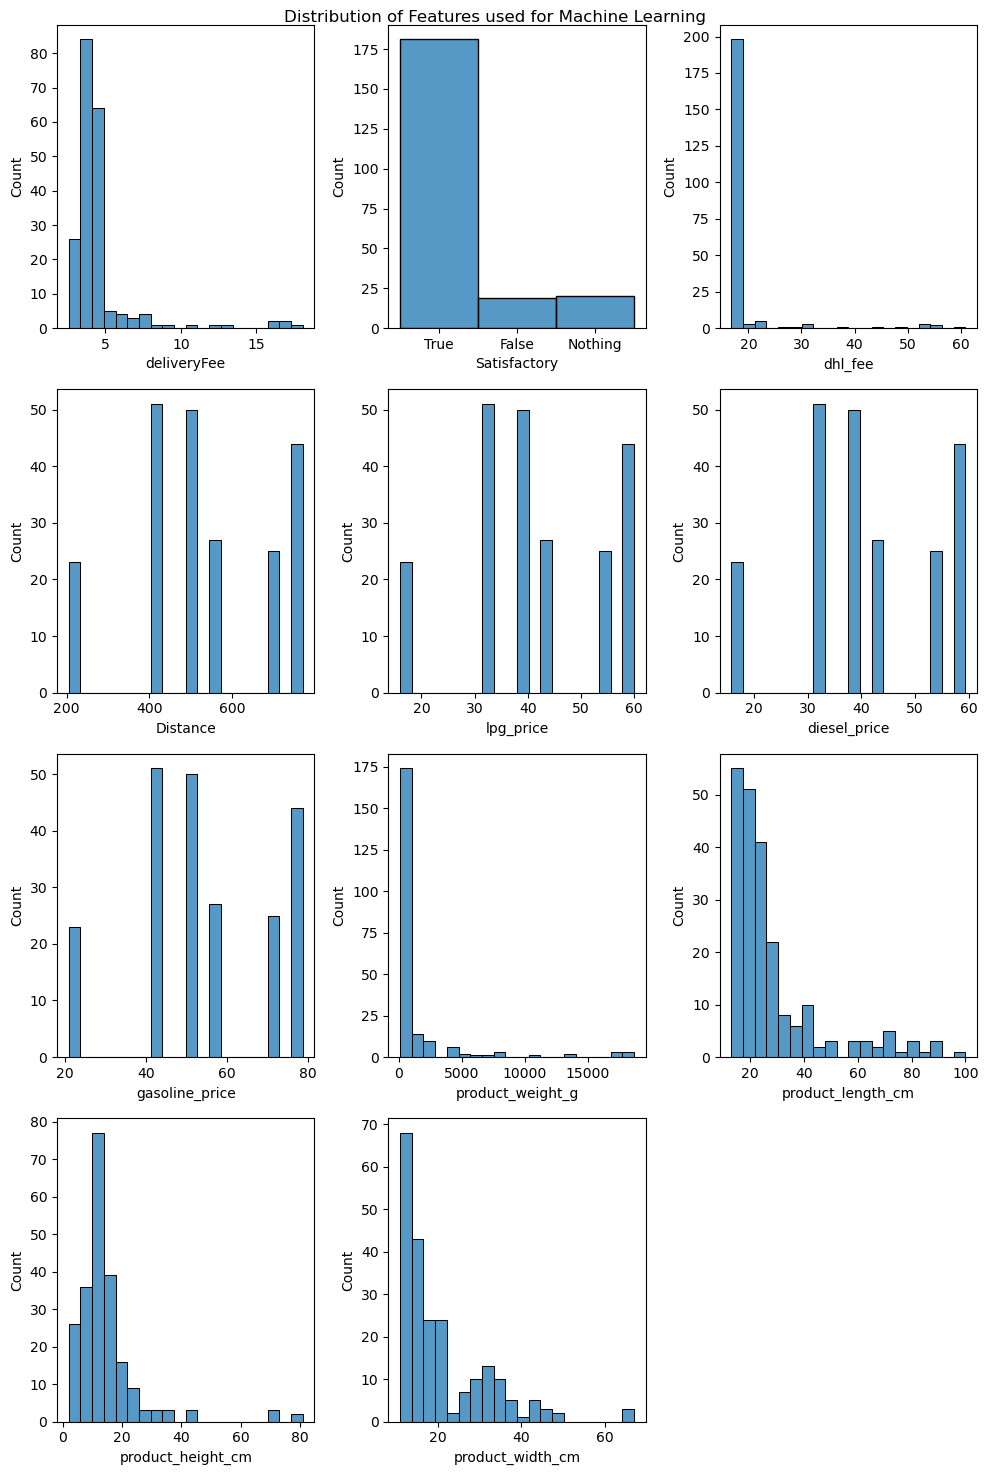

In [36]:
fig, axes = plt.subplots(4,3,figsize = (10,15))
ax = axes.flatten()

fig.suptitle("Distribution of Features used for Machine Learning")
for i, col in enumerate(new_requests_pandas.columns):
    sns.histplot(new_requests_pandas[col], ax=ax[i],bins= 20)
    
ax[-1].set_visible(False)
    

plt.tight_layout()
plt.show()

### 2.3 Min Max Scaling

In [12]:
vectorAssembler = VectorAssembler(inputCols = ['Distance', 'lpg_price',"diesel_price","gasoline_price",
                                               "product_weight_g", "product_length_cm",
                                               "product_height_cm","product_width_cm",
                                              "dhl_fee"], outputCol = 'features')

VA_requests = vectorAssembler.transform(new_requests)
VA_requests = VA_requests.select(["features","deliveryFee","Satisfactory"])
VA_requests.take(3)

[Row(features=DenseVector([550.5812, 42.8572, 42.3948, 56.2964, 667.0, 27.0, 19.0, 20.0, 17.05]), deliveryFee=4.070561, Satisfactory='True'),
 Row(features=DenseVector([550.5812, 42.8572, 42.3948, 56.2964, 1950.0, 17.0, 11.0, 12.0, 17.05]), deliveryFee=4.6860610000000005, Satisfactory='True'),
 Row(features=DenseVector([550.5812, 42.8572, 42.3948, 56.2964, 700.0, 20.0, 20.0, 20.0, 17.05]), deliveryFee=4.081061, Satisfactory='True')]

In [13]:
mms = MinMaxScaler(outputCol="scaled")

mms.setInputCol("features")
mms_fit = mms.fit(VA_requests)
transformed_data = mms_fit.transform(VA_requests)
transformed_data.toPandas()

,features,deliveryFee,Satisfactory,scaled
0,"[550.5811893, 42.85723978, 42.39475158, 56.296...",4.070561,True,"[0.6110515711004756, 0.6110515712383986, 0.611..."
1,"[550.5811893, 42.85723978, 42.39475158, 56.296...",4.686061,True,"[0.6110515711004756, 0.6110515712383986, 0.611..."
2,"[550.5811893, 42.85723978, 42.39475158, 56.296...",4.081061,True,"[0.6110515711004756, 0.6110515712383986, 0.611..."
3,"[550.5811893, 42.85723978, 42.39475158, 56.296...",3.845561,True,"[0.6110515711004756, 0.6110515712383986, 0.611..."
4,"[695.5684257, 54.14304626, 53.55876878, 71.121...",4.440798,False,"[0.8676431001135353, 0.8676431002078994, 0.867..."
...,...,...,...,...
215,"[414.9576716, 32.30030516, 31.95174072, 42.429...",3.559268,True,"[0.37103150698417825, 0.37103150708283666, 0.3..."
216,"[414.9576716, 32.30030516, 31.95174072, 42.429...",3.397768,True,"[0.37103150698417825, 0.37103150708283666, 0.3..."
217,"[414.9576716, 32.30030516, 31.95174072, 42.429...",3.516268,True,"[0.37103150698417825, 0.37103150708283666, 0.3..."
218,"[506.9220158, 39.45880971, 39.03299521, 51.832...",NaN,Nothing,"[0.533785638167558, 0.5337856382009548, 0.5337..."


### 2.4 Train-test split

In [15]:
#We only use those satisfied-with-the-fee customers data for the training set.
training_set = transformed_data.filter((~transformed_data.deliveryFee.isNull()) & (transformed_data.Satisfactory == "True"))
testing_set =  transformed_data.filter(transformed_data.deliveryFee.isNull())

In [16]:
training_set.show(5)

+--------------------+------------------+------------+--------------------+
|            features|       deliveryFee|Satisfactory|              scaled|
+--------------------+------------------+------------+--------------------+
|[550.5811893,42.8...|          4.070561|        True|[0.61105157110047...|
|[550.5811893,42.8...|4.6860610000000005|        True|[0.61105157110047...|
|[550.5811893,42.8...|          4.081061|        True|[0.61105157110047...|
|[550.5811893,42.8...|          3.845561|        True|[0.61105157110047...|
|[205.3060396,15.9...|          2.583126|        True|[0.0,0.0,0.0,0.0,...|
+--------------------+------------------+------------+--------------------+
only showing top 5 rows



In [38]:
print("Training Set Shape: ",(training_set.count(), len(training_set.columns)))

Training Set Shape:  (181, 4)


In [17]:
# Those are requests that we need to predict the delivery fee
testing_set.show(5)

+--------------------+-----------+------------+--------------------+
|            features|deliveryFee|Satisfactory|              scaled|
+--------------------+-----------+------------+--------------------+
|[550.5811893,42.8...|       null|     Nothing|[0.61105157110047...|
|[506.9220158,39.4...|       null|     Nothing|[0.53378563816755...|
|[506.9220158,39.4...|       null|     Nothing|[0.53378563816755...|
|[414.9576716,32.3...|       null|     Nothing|[0.37103150698417...|
|[770.3567915,59.9...|       null|     Nothing|[1.0,1.0,1.0,1.0,...|
+--------------------+-----------+------------+--------------------+
only showing top 5 rows



In [39]:
print("Testing Set Shape: ",(testing_set.count(), len(testing_set.columns)))

Testing Set Shape:  (20, 4)


## 3. Regression Model

### 3.1 Simple Regression Model

In [40]:
lr = LinearRegression(featuresCol = 'scaled', labelCol='deliveryFee')
lr_model = lr.fit(training_set)

print("Coeficient of the linear model: ",np.round(lr_model.coefficients,4))
print("Intercept of the linear model:", np.round(lr_model.intercept,4))

Coeficient of the linear model:  [0.5044 0.5044 0.5044 0.5044 9.2835 0.087  0.079  0.056  4.409 ]
Intercept of the linear model: 2.4871


In [41]:
print("RMSE error of the linear regression model on the training set: ",np.round(lr_model.summary.rootMeanSquaredError,4))
print("MAE error of the linear regression model on the training set: ",np.round(lr_model.summary.meanAbsoluteError,4))
print("R Square of the linear regression model on the training set: ",np.round(lr_model.summary.r2,4))

RMSE error of the linear regression model on the training set:  0.0
MAE error of the linear regression model on the training set:  0.0
R Square of the linear regression model on the training set:  1.0


In [42]:
print("RMSE error of the linear regression model on the test set: ",np.round(lr_model.evaluate(testing_set).rootMeanSquaredError,4))
print("MAE error of the linear regression model on the test set: ",np.round(lr_model.evaluate(testing_set).meanAbsoluteError,4))
print("R Square of the linear regression model on the test set: ",np.round(lr_model.evaluate(testing_set).r2,4))

Py4JJavaError: An error occurred while calling o364.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 250.0 failed 1 times, most recent failure: Lost task 0.0 in stage 250.0 (TID 2760) (DESKTOP-3KN2CJG executor driver): scala.MatchError: [3.825063578642757,null,1.0] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.regression.LinearRegressionSummary.$anonfun$metrics$1(LinearRegression.scala:923)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1234)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1235)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2358)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1172)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1166)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1259)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1226)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1212)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1212)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary$lzycompute(RegressionMetrics.scala:70)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary(RegressionMetrics.scala:62)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSreg$lzycompute(RegressionMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSreg(RegressionMetrics.scala:77)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.explainedVariance(RegressionMetrics.scala:88)
	at org.apache.spark.ml.regression.LinearRegressionSummary.<init>(LinearRegression.scala:934)
	at org.apache.spark.ml.regression.LinearRegressionModel.evaluate(LinearRegression.scala:727)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: scala.MatchError: [3.825063578642757,null,1.0] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.regression.LinearRegressionSummary.$anonfun$metrics$1(LinearRegression.scala:923)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1234)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1235)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


### 3.2 Lasso Regression Model

In [18]:
lasso_regression = LinearRegression(featuresCol="scaled", labelCol="deliveryFee", elasticNetParam=1)

In [45]:
#5-fold Cross Validation
grid_cv_lasso = ParamGridBuilder().addGrid(lasso_regression.regParam, [0.001, 0.01, 0.1, 1.0,10]).build()

evaluator_lasso = RegressionEvaluator(predictionCol="prediction", labelCol= "deliveryFee", metricName="rmse")

cross_validator_lasso = CrossValidator(estimator=lasso_regression,
                                 estimatorParamMaps=grid_cv_lasso,
                                 evaluator=evaluator_lasso,
                                 numFolds=5)

cv_lasso = cross_validator_lasso.fit(training_set)
best_lasso_regression = cv_lasso.bestModel

In [37]:
print("Coeficient of the best lasso model: ",np.round(best_lasso_regression.coefficients,4))
print("Intercept of the best lasso model:", np.round(best_lasso_regression.intercept,4))

Coeficient of the best lasso model:  [ 0.5202  0.5202  0.5202  0.5202  9.594   0.2763 -1.1783 -0.1595  4.0743]
Intercept of the best lasso model: 2.7011


In [42]:
print("RMSE error of the lasso model on the training set: ",np.round(best_lasso_regression.summary.rootMeanSquaredError,4))
print("MAE error of the lasso model on the training set: ",np.round(best_lasso_regression.summary.meanAbsoluteError,4))
print("R Square of the lasso model on the training set: ",np.round(best_lasso_regression.summary.r2,4))

RMSE error of the lasso model on the training set:  1.0067
MAE error of the lasso model on the training set:  0.8247
R Square of the lasso model on the training set:  0.8687


In [47]:
print("RMSE error of the lasso model on the test set: ",np.round(best_lasso_regression.evaluate(testing_set).rootMeanSquaredError,4))
print("MAE error of the lasso model on the test set: ",np.round(best_lasso_regression.evaluate(testing_set).meanAbsoluteError,4))
print("R Square of the lasso model on the test set: ",np.round(best_lasso_regression.evaluate(testing_set).r2,4))

RMSE error of the lasso model on the test set:  0.9554
MAE error of the lasso model on the test set:  0.8512
R Square of the lasso model on the test set:  0.8024


### 3.3 Ridge Regression Model

In [38]:
ridge_regression = LinearRegression(featuresCol="scaled", labelCol="deliveryFee", elasticNetParam=0)

In [46]:
#5-fold Cross Validation
grid_cv_ridge = ParamGridBuilder().addGrid(ridge_regression.regParam, [0.001, 0.01, 0.1, 1.0,10]).build()

evaluator_ridge = RegressionEvaluator(predictionCol="prediction", labelCol= "deliveryFee", metricName="rmse")

cross_validator_ridge = CrossValidator(estimator=ridge_regression,
                                 estimatorParamMaps=grid_cv_ridge,
                                 evaluator=evaluator_ridge,
                                 numFolds=5)

cv_ridge = cross_validator_ridge.fit(training_set)
best_ridge_regression = cv_ridge.bestModel

In [40]:
print("Coeficient of the best ridge model: ",np.round(best_ridge_regression.coefficients,4))
print("Intercept of the best ridge model:", np.round(best_ridge_regression.intercept,4))

Coeficient of the best ridge model:  [ 0.5293  0.5293  0.5293  0.5293 10.9319  0.3519 -1.4903 -0.519   3.062 ]
Intercept of the best ridge model: 2.7267


In [41]:
print("RMSE error of the ridge model on the training set: ",np.round(best_ridge_regression.summary.rootMeanSquaredError,4))
print("MAE error of the ridge model on the training set: ",np.round(best_ridge_regression.summary.meanAbsoluteError,4))
print("R Square of the ridge model on the training set: ",np.round(best_ridge_regression.summary.r2,4))

RMSE error of the ridge model on the training set:  1.0053
MAE error of the ridge model on the training set:  0.8235
R Square of the ridge model on the training set:  0.869


In [48]:
print("RMSE error of the ridge model on the test set: ",np.round(best_ridge_regression.evaluate(testing_set).rootMeanSquaredError,4))
print("MAE error of the ridge model on the test set: ",np.round(best_ridge_regression.evaluate(testing_set).meanAbsoluteError,4))
print("R Square of the ridge model on the test set: ",np.round(best_ridge_regression.evaluate(testing_set).r2,4))

RMSE error of the ridge model on the test set:  0.9555
MAE error of the ridge model on the test set:  0.8525
R Square of the ridge model on the test set:  0.8023
